In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
from pathlib import Path
import numpy as np
from access.profiling.access_models import ACCESSOM3Profiling
from access.config.accessom3_layout_input import OM3LayoutSearchConfig, generate_om3_core_layouts_from_node_count, quote_env_for_yaml


In [60]:
repository_url = "https://github.com/ACCESS-NRI/access-om3-configs.git"
start_point = "b0eddf9"
test_path = Path("/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings")
repository_directory = "Scaling_MC-25km-ryf-10days"
branch_name_prefix = "MC-25km-ryf-10days"

work_dir = test_path / repository_directory
archive_dir = test_path / "archive" / repository_directory

pool_map = {
    "atm": "shared",
    "cpl": "shared",
    "ice": "shared",
    "rof": "shared",
    "ocn": "ocn",
}

pool_order = ["shared", "ocn"]

cores_per_node = 104

node_count = 30
node_list = list(range(1, node_count + 1, 2))

blocks_per_node_list = [
    8,
    4,
    4,
    4,
    4,
    *([2] * (len(node_list)-5)),
]

max_ratio_to_baseline = [
    *([{"ocn": 25.0}] * len(node_list)),
]

min_ratio_to_baseline = [
    {"ocn": 3.0},
    {"ocn": 5.0},
    {"ocn": 6.0},
    {"ocn": 8.0},
    *([{"ocn": 10.0}]*3),
    {"ocn": 8.0},
    *([{"ocn": 10.0}] * (len(node_list) - 8)),
]

min_blocks={"shared": 1, "ocn": 1}

control_options = {
    "config.yaml": {
        "metadata": {"enable": True}
    }
}

clock_attributes = {
    "restart_n": 10,
    "restart_option": "ndays",
    "stop_n": 10,
    "stop_option": "ndays",
}

walltime_hrs = 10  # same for all node counts

def layout_search_config_builder(num_nodes: float) -> OM3LayoutSearchConfig:
    """
    Build per-node om3 layout search settings.
    """
    n = int(num_nodes)
    i = node_list.index(n)

    return OM3LayoutSearchConfig(
        scheduler="pbs",
        queue="normalsr",
        pool_map=pool_map,
        pool_order=pool_order,
        blocks_per_node=blocks_per_node_list[i],
        baseline_pool_name="shared",
        eps=1e-6,
        max_ratio_to_baseline=max_ratio_to_baseline[i],
        min_ratio_to_baseline=min_ratio_to_baseline[i],
        min_blocks=min_blocks,
        enable_esmf_trace=True,
        trace_pets=None,  # inject petlists per-layout in overrides
    )

all_layouts = []
for ii, n in enumerate(node_list):
    cfg = layout_search_config_builder(n)

    layouts = generate_om3_core_layouts_from_node_count(
        num_nodes=n,
        cores_per_node=cores_per_node,
        layout_search_config=cfg,
    )

    print(f"\n {ii+1} num_nodes={n} layouts={len(layouts)}")
    for L in layouts:
        shared = L.pool_ntasks["shared"]
        ocn = L.pool_ntasks["ocn"]
        print(f"  shared_ntasks={shared:4d} ocn_ntasks={ocn:4d} ncpus={L.ncpus:4d} rootpe={L.pool_rootpe}")

    all_layouts.extend(layouts)

print(f"\nTOTAL layouts across node_list: {len(all_layouts)}")



 1 num_nodes=1 layouts=2
  shared_ntasks=  13 ocn_ntasks=  91 ncpus= 104 rootpe={'shared': 0, 'ocn': 13}
  shared_ntasks=  26 ocn_ntasks=  78 ncpus= 104 rootpe={'shared': 0, 'ocn': 26}

 2 num_nodes=3 layouts=2
  shared_ntasks=  26 ocn_ntasks= 286 ncpus= 312 rootpe={'shared': 0, 'ocn': 26}
  shared_ntasks=  52 ocn_ntasks= 260 ncpus= 312 rootpe={'shared': 0, 'ocn': 52}

 3 num_nodes=5 layouts=2
  shared_ntasks=  26 ocn_ntasks= 494 ncpus= 520 rootpe={'shared': 0, 'ocn': 26}
  shared_ntasks=  52 ocn_ntasks= 468 ncpus= 520 rootpe={'shared': 0, 'ocn': 52}

 4 num_nodes=7 layouts=2
  shared_ntasks=  52 ocn_ntasks= 676 ncpus= 728 rootpe={'shared': 0, 'ocn': 52}
  shared_ntasks=  78 ocn_ntasks= 650 ncpus= 728 rootpe={'shared': 0, 'ocn': 78}

 5 num_nodes=9 layouts=2
  shared_ntasks=  52 ocn_ntasks= 884 ncpus= 936 rootpe={'shared': 0, 'ocn': 52}
  shared_ntasks=  78 ocn_ntasks= 858 ncpus= 936 rootpe={'shared': 0, 'ocn': 78}

 6 num_nodes=11 layouts=2
  shared_ntasks=  52 ocn_ntasks=1092 ncpus=

In [61]:
def walltime(_num_nodes: float) -> float:
    return walltime_hrs

def block_overrides_builder(layout, num_nodes: float) -> dict:
    """
    Build per-layout block overrides.
    """
    _ = num_nodes
    ocn_rootpe = layout.pool_rootpe["ocn"]
    return {
        "MOM_input": {
            "MASKTABLE": "REMOVE",
            "LAYOUT": "REMOVE",
            "IO_LAYOUT": "REMOVE",
        },
        "nuopc.runconfig": {
            "CLOCK_attributes": clock_attributes,
        },
        "config.yaml": {
            "env": quote_env_for_yaml({
                "ESMF_RUNTIME_PROFILE_OUTPUT": "SUMMARY",
                "ESMF_RUNTIME_TRACE_PETLIST": f"0 {ocn_rootpe}",
            })
        },
    }

In [62]:
# Instantiate the om3 manager
om3_manager = ACCESSOM3Profiling(work_dir=work_dir, archive_dir=archive_dir)

# set control experiment base
om3_manager.set_control(repository_url, start_point)

# set repository_directory
om3_manager._repository_directory = repository_directory

# set nruns
om3_manager._nruns = 1

# startfrom_restart
om3_manager._startfrom_restart = "cold"

# generate perturbation experiments
om3_manager.generate_scaling_experiments(
    num_nodes_list=node_list,
    control_options=control_options,
    cores_per_node=cores_per_node,
    branch_name_prefix=branch_name_prefix,
    walltime=walltime,
    layout_search_config_builder=layout_search_config_builder,
    block_overrides_builder=block_overrides_builder,
)


-- Test directory /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days already exists!
Cloned repository from https://github.com/ACCESS-NRI/access-om3-configs.git to directory: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/Scaling_MC-25km-ryf-10days
Created and checked out new branch: ctrl
laboratory path:  /scratch/tm70/ml0072/access-om3
binary path:  /scratch/tm70/ml0072/access-om3/bin
input path:  /scratch/tm70/ml0072/access-om3/input
work path:  /scratch/tm70/ml0072/access-om3/work
archive path:  /scratch/tm70/ml0072/access-om3/archive
Updated metadata. Experiment UUID: 07fb1724-375f-4b79-bf72-f86b9e695f60
Added archive symlink to /scratch/tm70/ml0072/access-om3/archive/Scaling_MC-25km-ryf-10days-ctrl-07fb1724
To change directory to control directory run:
  cd /g/data/tm70/ml0072/COMMON/git_rep

In [63]:
# run experiments
om3_manager.run_experiments()

* Current Branch: MC-25km-ryf-10days_node_29_queue_normalsr_shared_260_ocn_2756
    experiment_uuid: 123f76ac-5af1-4326-b571-8dd178adba22
Branch: MC-25km-ryf-10days_node_11_queue_normalsr_shared_104_ocn_1040
    experiment_uuid: 08f17df1-9b7d-4a54-a5f7-e5fd34b293f6
Branch: MC-25km-ryf-10days_node_11_queue_normalsr_shared_52_ocn_1092
    experiment_uuid: 2ad5f910-ae49-4074-8f3e-2409db31658a
Branch: MC-25km-ryf-10days_node_13_queue_normalsr_shared_104_ocn_1248
    experiment_uuid: 40036a02-ea39-4e1f-a76d-717e89fe9455
Branch: MC-25km-ryf-10days_node_13_queue_normalsr_shared_52_ocn_1300
    experiment_uuid: 7ee040fd-781b-40f7-aee9-47e29edaff4f
Branch: MC-25km-ryf-10days_node_15_queue_normalsr_shared_104_ocn_1456
    experiment_uuid: b08cd9cf-f2c5-4853-b4dc-646494dad287
Branch: MC-25km-ryf-10days_node_15_queue_normalsr_shared_156_ocn_1404
    experiment_uuid: ae1a5242-d431-48b5-9ecb-a010f27a8041
Branch: MC-25km-ryf-10days_node_17_queue_normalsr_shared_104_ocn_1664
    experiment_uuid: 518ea

In [7]:
# accessom3_profiling.purge_experiments(dry_run=False, hard=True, remove_repo_dir=True)

In [64]:
import re
from access.esmf_trace import run_from_config, post_summary_from_config
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.library import ACCESSRunConfigBuilder, ACCESSPostSummaryConfigBuilder

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

In [65]:
om3_manager._repository_directory

'Scaling_MC-25km-ryf-10days'

In [66]:
om3_manager.work_dir

PosixPath('/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days')

In [67]:
branches = list(om3_manager.experiments.keys())
repository_directory = om3_manager._repository_directory
work_dir = om3_manager.work_dir
count=len(branches)
postprocess_prefix = "postprocessing"
post_base_path = work_dir / f"{postprocess_prefix}_{repository_directory}"
exact_paths = paths = [exp.path / "archive" for exp in om3_manager.experiments.values()]

model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
]

branch_pattern = re.compile(
    r"_node_(?P<node>\d+)_.*?_shared_(?P<shared>\d+)_ocn_(?P<ocn>\d+)"
)

builder = ACCESSRunConfigBuilder(
    branches=branches,
    post_base_path=post_base_path,
    exact_paths=exact_paths,
    model_component=model_component,
    branch_pattern=branch_pattern,
    pets_components=["shared"],
    max_workers=8,
)
cfg_run = builder.build_config()

In [68]:
cfg_run

{'default_settings': {'post_base_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days',
  'model_component': ['[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
   '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'],
  'stream_prefix': 'esmf_stream',
  'xaxis_datetime': False,
  'separate_plots': False,
  'cmap': 'tab10',
  'renderer': 'browser',
  'show_html': False,
  'max_workers': 8},
 'runs': [{'exact_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/Scaling_MC-25km-ryf-10days/archive',
   'base_prefix': 'MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91',
   'pets': '0,13'},
  {'exact_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-e

In [69]:
run_from_config(cfg_run)

-- Using up to 8 parallel workers
-- Running 33 jobs with up to 8 parallel workers...
[postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_26_ocn_494/output000] success!
[postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_52_ocn_260/output000] success!
[postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78/output000] success!
[postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_52_ocn_676/output000] success!
[postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000] success!
[postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_26_ocn_286/output000] success!
[postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_78_ocn_650/output000] success!
[postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_52_ocn_468/output000] success!
[postprocessing_MC-25km-ryf-10days_node_9_queue_normalsr_shared_52_ocn_884/output000] success!
[postprocessing_MC-25km-ryf-10days_node_13_queue_normalsr_sha

In [112]:
save_json_path = post_base_path / "post_summary_config.json"
builder = ACCESSPostSummaryConfigBuilder(
    post_base_path=post_base_path,
    model_component=model_component,
    stats_start_index=2,
    stats_end_index=-1,
    # stats_start_index=None,
    # stats_end_index=None,
    save_json_path=save_json_path,
)

In [113]:
def parse_pets(pets):
    if pets is None:
        return None
    if isinstance(pets, (list, tuple, set)):
        return [int(p) for p in pets]
    
    # assume string like "0,13"
    return [int(p.strip()) for p in pets.split(",") if p.strip()]

runs = [
    {
        "name": postprocess_prefix+"_"+r["base_prefix"],
        "pets": parse_pets(r["pets"]),
    } for r in cfg_run["runs"]
    ]

cfg_summary = builder.build_config(runs=runs)
print(cfg_summary)

{'default_settings': {'post_base_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days', 'timeseries_suffix': '_timeseries.json', 'model_component': ['[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1', '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'], 'stats_start_index': 2, 'stats_end_index': -1, 'save_json_path': '/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days/post_summary_config.json'}, 'runs': [{'name': 'postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91', 'pets': [0, 13]}, {'name': 'postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78', 'pets': [0, 26]}, {'name': 'postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_share

In [114]:
post_summary_from_config(cfg_summary)

-- saved per-run summary JSON: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days/post_summary_config.json
-- saved per-run summary JSON: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days/post_summary_config.json
-- saved per-run summary JSON: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days/post_summary_config.json
-- saved per-run summary JSON: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/new_workflow/om3_scalings/Scaling_MC-25km-ryf-10days/postprocessing_Scaling_MC-25km-ryf-10days/post_summary_config.json
-- saved per-run summary JSO

In [115]:
parquet_path = test_path / repository_directory / f"{postprocess_prefix}_{repository_directory}" / "post_summary_config_table.parquet"
df = pd.read_parquet(parquet_path)
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,1914,0.013664,2.809601,0.087677,0.127775,0.112373,0,13
postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,957,6.248405,19.345935,7.889305,6.323528,3.801563,13,13
postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,1914,0.013664,2.809601,0.087677,0.127775,0.112373,0,13
postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,957,6.248405,19.345935,7.889305,6.323528,3.801563,13,13
postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,1914,0.009414,0.472310,0.055655,0.054666,0.044857,0,26
...,...,...,...,...,...,...,...,...
postprocessing_MC-25km-ryf-10days_node_29_queue_normalsr_shared_208_ocn_2808/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,957,0.224326,2.109523,0.333128,0.249313,0.229170,208,208
postprocessing_MC-25km-ryf-10days_node_29_queue_normalsr_shared_260_ocn_2756/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,1914,0.000674,0.768493,0.011144,0.005709,0.048059,0,260
postprocessing_MC-25km-ryf-10days_node_29_queue_normalsr_shared_260_ocn_2756/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,957,0.226633,2.255040,0.327835,0.241667,0.233696,260,260


In [116]:
new_vars = {
    "[total] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    ],
    # "[OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    # ],
    # "[MED-TO-OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    # ],
}


In [117]:
def strip_prefix(case: str, branch_name_prefix: str | None):
    if not branch_name_prefix:
        return case
    prefix = f"postprocessing_{branch_name_prefix}_"
    return case[len(prefix):] if case.startswith(prefix) else case

_RE_OCN = re.compile(r"_ocn_(\d+)")
_RE_SHARED = re.compile(r"_shared_(\d+)")

def cores_from_case(case: str) -> float:
    ms = _RE_SHARED.search(case)
    mo = _RE_OCN.search(case)
    if ms and mo:
        return float(int(ms.group(1)) + int(mo.group(1)))
    return np.nan

_RE_NODE = re.compile(r"node_(\d+)")

def node_from_case(case: str) -> float:
    m = _RE_NODE.search(case)
    return float(m.group(1)) if m else np.nan

def prepare_df(
    stats_df: pd.DataFrame,
    *,
    ycol: str,
    new_vars: dict[str, list[str]],
    branch_name_prefix: str | None = None,
    case_order: list[str] | None = None,
):
    df = stats_df.copy()
    idx = df.index.to_series().astype(str)

    df["__case_raw"] = idx.str.split("/", n=1).str[0]
    df["__case"] = df["__case_raw"].map(
        lambda s: strip_prefix(s, branch_name_prefix)
    )

    blocks = []

    for comp_name, patterns in new_vars.items():
        mask = idx.apply(lambda s: any(p in s for p in patterns))
        sub = df[mask].copy()
        if sub.empty:
            continue

        g = sub.groupby("__case", as_index=False).sum(numeric_only=True)
        g["__component"] = comp_name
        blocks.append(g)

    out = pd.concat(blocks, ignore_index=True)

    out["cores"] = out["__case"].map(cores_from_case)
    out["node"] = out["__case"].map(node_from_case)

    keep = out[["__case", "__component", "node", "cores", ycol]].copy()

    return keep

In [118]:
plot_df = prepare_df(
    stats_df=df,
    ycol="tmedian",
    new_vars=new_vars,
    branch_name_prefix="MC-100km-ryf-10days",
)

In [119]:
plot_df

,__case,__component,node,cores,tmedian
0,postprocessing_MC-25km-ryf-10days_node_11_queu...,[total] RunPhase1,11.0,1144.0,1.130371
1,postprocessing_MC-25km-ryf-10days_node_11_queu...,[total] RunPhase1,11.0,1144.0,1.074017
2,postprocessing_MC-25km-ryf-10days_node_13_queu...,[total] RunPhase1,13.0,1352.0,1.017365
3,postprocessing_MC-25km-ryf-10days_node_13_queu...,[total] RunPhase1,13.0,1352.0,0.922491
4,postprocessing_MC-25km-ryf-10days_node_15_queu...,[total] RunPhase1,15.0,1560.0,0.904137
5,postprocessing_MC-25km-ryf-10days_node_15_queu...,[total] RunPhase1,15.0,1560.0,0.807965
6,postprocessing_MC-25km-ryf-10days_node_17_queu...,[total] RunPhase1,17.0,1768.0,0.837907
7,postprocessing_MC-25km-ryf-10days_node_17_queu...,[total] RunPhase1,17.0,1768.0,0.714413
8,postprocessing_MC-25km-ryf-10days_node_19_queu...,[total] RunPhase1,19.0,1976.0,0.808163
9,postprocessing_MC-25km-ryf-10days_node_19_queu...,[total] RunPhase1,19.0,1976.0,0.668113


In [120]:
def plot_scaling(
    plot_df: pd.DataFrame,
    ycol: str,
    mode: str = "scaling", # scaling | speedup | efficiency
    selection: str = "all", # all | best_core
    ref_index: int = 0,
    logx: bool = False,
    logy: bool = False,
    show_case_names: bool = False,
    title: str | None = None,
    figsize=(8, 6),
):
    def metric(x, t, x0, t0):
        if mode == "scaling":
            return t, "Walltime / step (s)"
        if mode == "speedup":
            return t0 / t, "Speedup"
        if mode == "efficiency":
            return (t0 * x0) / (t * x), "Parallel efficiency"

    def ideal(x, x0, t0):
        if mode == "scaling":
            return t0 * (x0 / x)
        if mode == "speedup":
            return x / x0
        return np.ones_like(x)

    fig, ax = plt.subplots(figsize=figsize)
    printed = {}

    # log-x tick labels
    xt_all = np.array(sorted(set(plot_df["cores"].astype(int).tolist())), dtype=float)

    for comp, dfc in plot_df.groupby("__component"):
        dfc = dfc.sort_values("cores")

        # component legend once
        ax.plot([], [], "o-", label=comp)

        # build selection ONCE
        if selection == "best_core":
            sel = (
                dfc.sort_values(ycol)
                   .groupby("cores", as_index=False)
                   .first()
                   .sort_values("cores")
            )
            baseline_df = sel  # ensures ideal crosses the plotted ref point
        elif selection == "all":
            sel = dfc
            baseline_df = (
                dfc.groupby("cores", as_index=False)[ycol]
                   .median()
                   .sort_values("cores")
            )
        else:
            raise ValueError("selection must be all | best_core")

        # baseline
        r = ref_index if 0 <= ref_index < len(baseline_df) else 0
        core0 = float(baseline_df["cores"].iloc[r])
        t0 = float(baseline_df[ycol].iloc[r])

        if selection == "best_core":
            x = sel["cores"].to_numpy(float)
            t = sel[ycol].to_numpy(float)
            y, ylabel = metric(x, t, core0, t0)

            ax.scatter(x, y, s=70)
            ax.plot(x, ideal(x, core0, t0), "--", alpha=0.6)

            if show_case_names:
                for xi, yi, case in zip(x, y, sel["__case"].tolist()):
                    ax.text(xi, yi, f" {case}", fontsize=8, va="center")

            printed[comp] = (
                sel[["cores", "__case"]]
                .assign(combine=y)
                .rename(columns={"__case": "case"})
                .set_index("cores")
                .sort_index()
            )

        else:  # selection == "all"
            for case, dcase in dfc.groupby("__case"):
                dcase = dcase.sort_values("cores")
                x = dcase["cores"].to_numpy(float)
                t = dcase[ycol].to_numpy(float)
                y, ylabel = metric(x, t, core0, t0)

                ln, = ax.plot(x, y, "o-", alpha=0.7)
                ax.plot(x, ideal(x, core0, t0), "--", alpha=0.25, color=ln.get_color())

                if show_case_names:
                    ax.text(x[-1], y[-1], f" {case}", fontsize=8, va="center")

            printed[comp] = (
                dfc[["cores", "__case", ycol]]
                .rename(columns={"__case": "case", ycol: "combine"})
                .sort_values(["cores", "case"])
                .reset_index(drop=True)
            )

    # axes
    if logx:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(mticker.NullFormatter())
        ax.xaxis.set_minor_locator(mticker.FixedLocator(xt_all))
        ax.xaxis.set_minor_formatter(mticker.FixedFormatter([str(int(v)) for v in xt_all]))
        ax.tick_params(axis="x", which="minor", labelsize=10)

    if logy:
        ax.set_yscale("log")

    ax.set_xlabel("Total CPUs")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"{mode.capitalize()} ({selection})")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Component", loc="upper right")

    plt.tight_layout()
    plt.show()

    for comp, tbl in printed.items():
        print(f"\n\t{comp}")
        print("__output_name\tcombine")
        print(tbl.to_string())

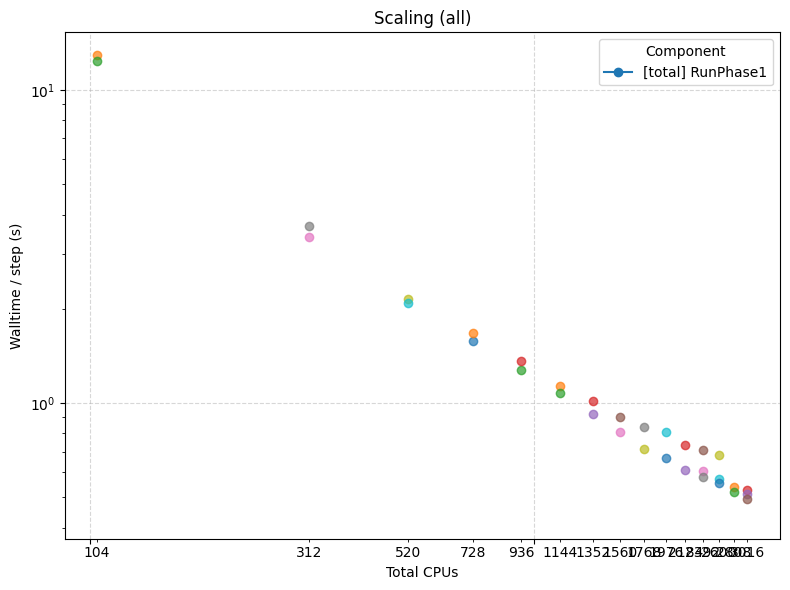


	[total] RunPhase1
__output_name	combine
     cores                                                                          case    combine
0    104.0      postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_13_ocn_91  12.902605
1    104.0      postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78  12.382833
2    312.0     postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_26_ocn_286   3.395568
3    312.0     postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_52_ocn_260   3.667982
4    520.0     postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_26_ocn_494   2.155061
5    520.0     postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_52_ocn_468   2.093498
6    728.0     postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_52_ocn_676   1.579734
7    728.0     postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_78_ocn_650   1.671615
8    936.0     postprocessing_MC-25km-ryf-10days_node_9_qu

In [121]:
plot_scaling(plot_df, ycol="tmedian", selection="all", mode="scaling", logx=True, logy=True, ref_index=0)

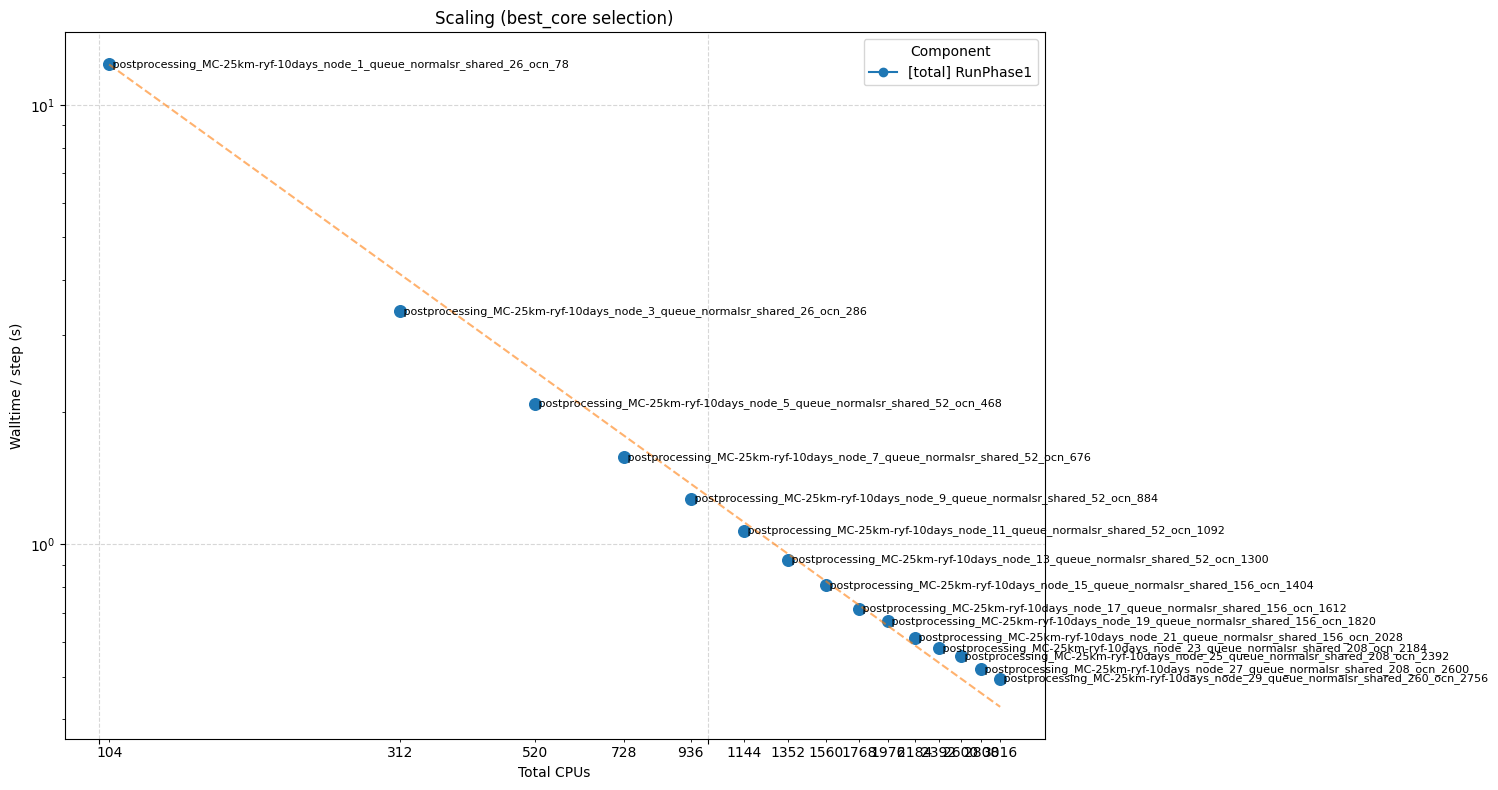


	[total] RunPhase1
__output_name	combine
                                                                                case    combine
cores                                                                                          
104.0       postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78  12.382833
312.0      postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_26_ocn_286   3.395568
520.0      postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_52_ocn_468   2.093498
728.0      postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_52_ocn_676   1.579734
936.0      postprocessing_MC-25km-ryf-10days_node_9_queue_normalsr_shared_52_ocn_884   1.272396
1144.0   postprocessing_MC-25km-ryf-10days_node_11_queue_normalsr_shared_52_ocn_1092   1.074017
1352.0   postprocessing_MC-25km-ryf-10days_node_13_queue_normalsr_shared_52_ocn_1300   0.922491
1560.0  postprocessing_MC-25km-ryf-10days_node_15_queue_normalsr_shared_156_ocn_1404   0.80796

In [122]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="scaling", logx=True, logy=True, show_case_names=True, ref_index=0, figsize=(15, 8), title="Scaling (best_core selection)")

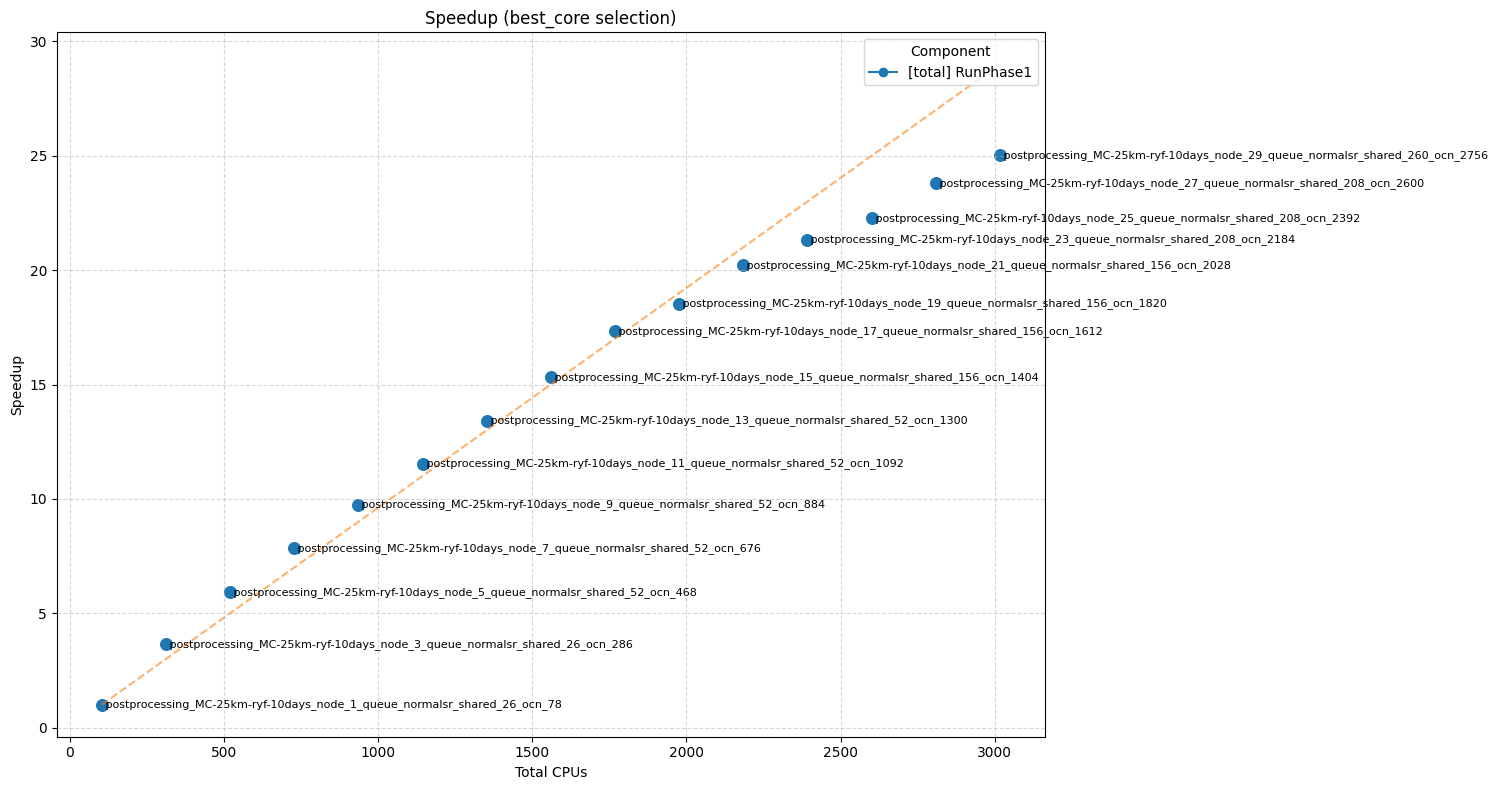


	[total] RunPhase1
__output_name	combine
                                                                                case    combine
cores                                                                                          
104.0       postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78   1.000000
312.0      postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_26_ocn_286   3.646764
520.0      postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_52_ocn_468   5.914899
728.0      postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_52_ocn_676   7.838558
936.0      postprocessing_MC-25km-ryf-10days_node_9_queue_normalsr_shared_52_ocn_884   9.731901
1144.0   postprocessing_MC-25km-ryf-10days_node_11_queue_normalsr_shared_52_ocn_1092  11.529457
1352.0   postprocessing_MC-25km-ryf-10days_node_13_queue_normalsr_shared_52_ocn_1300  13.423260
1560.0  postprocessing_MC-25km-ryf-10days_node_15_queue_normalsr_shared_156_ocn_1404  15.32594

In [123]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="speedup", show_case_names=True, ref_index=0, figsize=(15, 8), title="Speedup (best_core selection)")

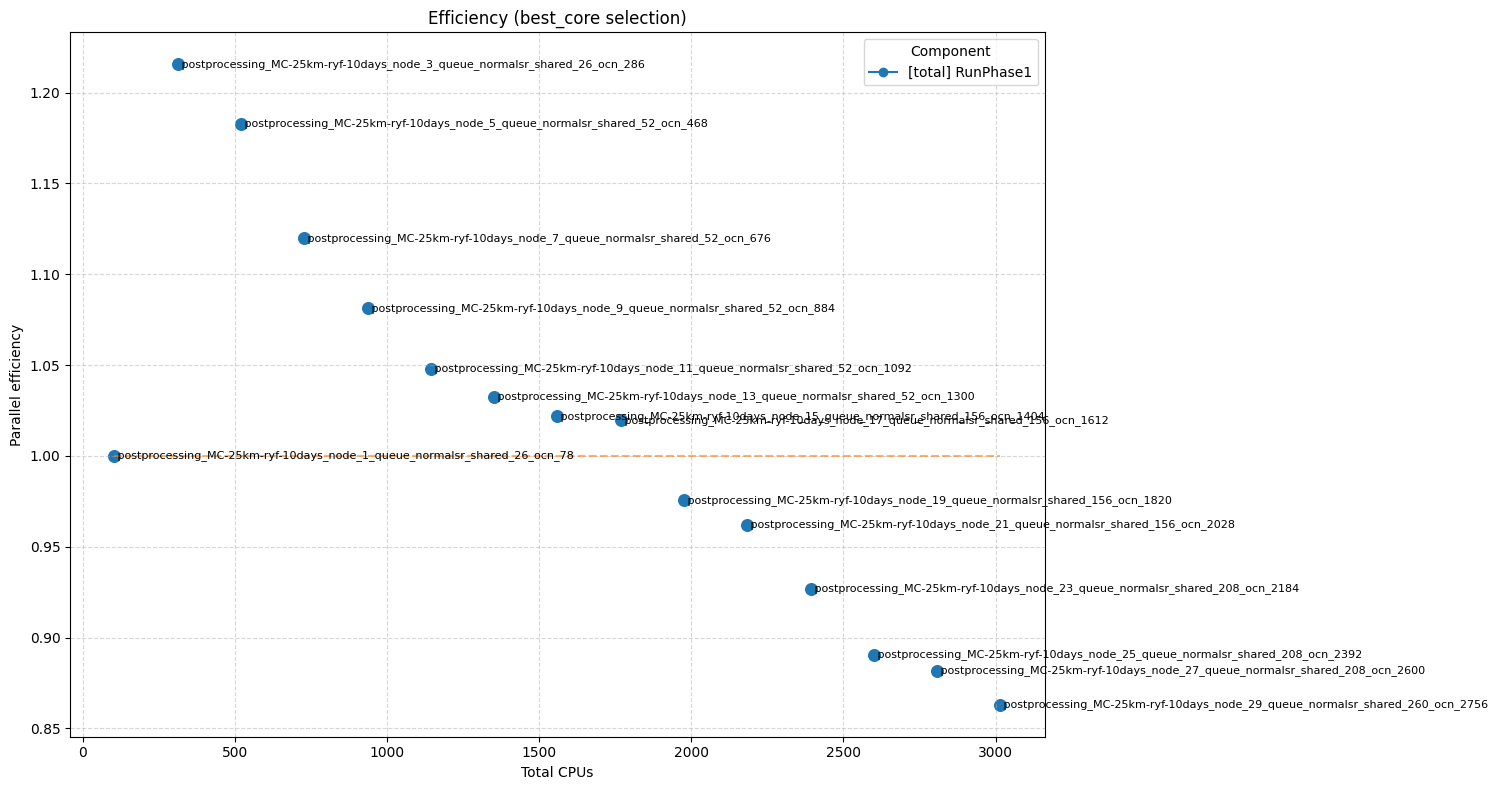


	[total] RunPhase1
__output_name	combine
                                                                                case   combine
cores                                                                                         
104.0       postprocessing_MC-25km-ryf-10days_node_1_queue_normalsr_shared_26_ocn_78  1.000000
312.0      postprocessing_MC-25km-ryf-10days_node_3_queue_normalsr_shared_26_ocn_286  1.215588
520.0      postprocessing_MC-25km-ryf-10days_node_5_queue_normalsr_shared_52_ocn_468  1.182980
728.0      postprocessing_MC-25km-ryf-10days_node_7_queue_normalsr_shared_52_ocn_676  1.119794
936.0      postprocessing_MC-25km-ryf-10days_node_9_queue_normalsr_shared_52_ocn_884  1.081322
1144.0   postprocessing_MC-25km-ryf-10days_node_11_queue_normalsr_shared_52_ocn_1092  1.048132
1352.0   postprocessing_MC-25km-ryf-10days_node_13_queue_normalsr_shared_52_ocn_1300  1.032558
1560.0  postprocessing_MC-25km-ryf-10days_node_15_queue_normalsr_shared_156_ocn_1404  1.021730
1768.0  

In [124]:
plot_scaling(plot_df, ycol="tmedian", selection="best_core", mode="efficiency", show_case_names=True, ref_index=0, figsize=(15, 8), title="Efficiency (best_core selection)")